<a id=top-page></a>

# `pykitPIV` demo: Integrate synthetic image generation with training a convolutional neural network (CNN)

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#synthetic-images">Generate synthetic images with pykitPIV</a></li>
        <ul>
        <li><a href="#synthetic-images-training-set">Training set</a></li>
        <li><a href="#synthetic-images-testing-set">Testing set</a></li>
        </ul>
    <li><a href="#train-LIMA">Train LIMA with the generated images</a></li>
        <ul>
        <li><a href="#train-LIMA-input-data">Prepare input dataset for LIMA</a></li>
        <li><a href="#train-LIMA-train">Begin training</a></li>
        </ul>
    <li><a href="#predict">Make predictions from the trained network</a></li>
</ol>
<p></p>
</div>
<br>

***

In [1]:
import argparse
import os
import time
import pytorch_lightning as pl
import torchvision.transforms
from rich import print
from torch.utils.data import DataLoader
import lima
import glob
import h5py
import skimage.io as io
import torch
from torch.utils.data import Dataset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
from pykitPIV import Particle, FlowField, Motion, Image

<a id=synthetic-images></a>

***

## Generate synthetic images with `pykitPIV`

[Go to the top](#top-page)

In [3]:
image_size = (128,128)

In [4]:
size_buffer = 10

In [5]:
figsize = (5,3)

In [6]:
def generate_images(n_images, random_seed):

    # Instantiate an object of the Particle class:
    particles = Particle(n_images,
                         size=image_size,
                         size_buffer=size_buffer,
                         diameters=(4,4.1),
                         distances=(1,2),
                         densities=(0.05,0.1),
                         signal_to_noise=(5,20),
                         diameter_std=0.2,
                         seeding_mode='random',
                         random_seed=random_seed)

    # Instantiate an object of the FlowField class:
    flowfield = FlowField(n_images,
                          size=image_size,
                          size_buffer=size_buffer,
                          random_seed=random_seed)

    flowfield.generate_random_velocity_field(gaussian_filters=(10,11),
                                             n_gaussian_filter_iter=20,
                                             displacement=(0,10))

    # Instantiate an object of the Motion class:
    motion = Motion(particles, 
                    flowfield, 
                    time_separation=0.1)

    # Instantiate an object of the Image class:
    image = Image(random_seed=random_seed)

    # Prepare images - - - - - - - - - - - - - - - - - - 

    image.add_particles(particles)

    image.add_flowfield(flowfield)
            
    motion.forward_euler(n_steps=10)
    
    image.add_motion(motion)
    
    image.add_reflected_light(exposures=(0.7,0.8),
                              maximum_intensity=2**16-1,
                              laser_beam_thickness=1,
                              laser_over_exposure=1,
                              laser_beam_shape=0.95,
                              alpha=1/10)

    image.remove_buffers()

    return image

<a id=synthetic-images-training-set></a>

### Training set

[Go to the top](#top-page)

The training set will have 10 image pairs:

In [7]:
n_images = 10

We fix a random seed for generating the training set of PIV images:

In [8]:
training_random_seed = 100

In [9]:
image_train = generate_images(n_images, training_random_seed)

image_pairs_train = image_train.image_pairs_to_tensor()
targets_train = image_train.targets_to_tensor()

Particles added to the image.
Velocity field added to the image.
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
Buffers removed from images I1.
Buffers removed from images I2.
Buffers removed from the velocity field.


In [10]:
image_train.save_to_h5({'I': image_pairs_train, 'targets': targets_train}, filename='PIV-dataset-train.h5')

Dataset saved.


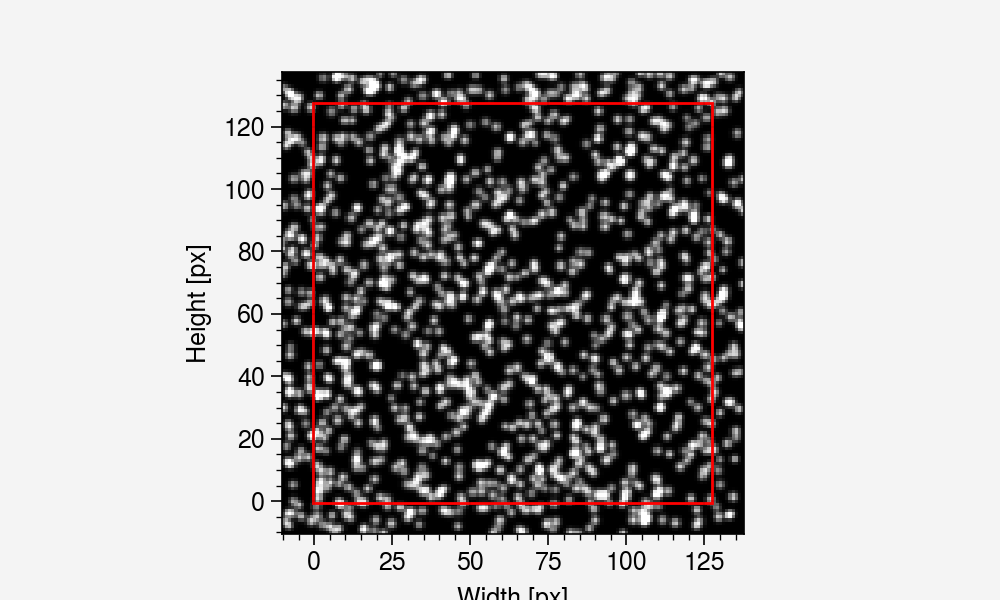

In [11]:
image_train.plot(0,
                 instance=1,
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 cmap='Greys_r',
                 figsize=figsize);

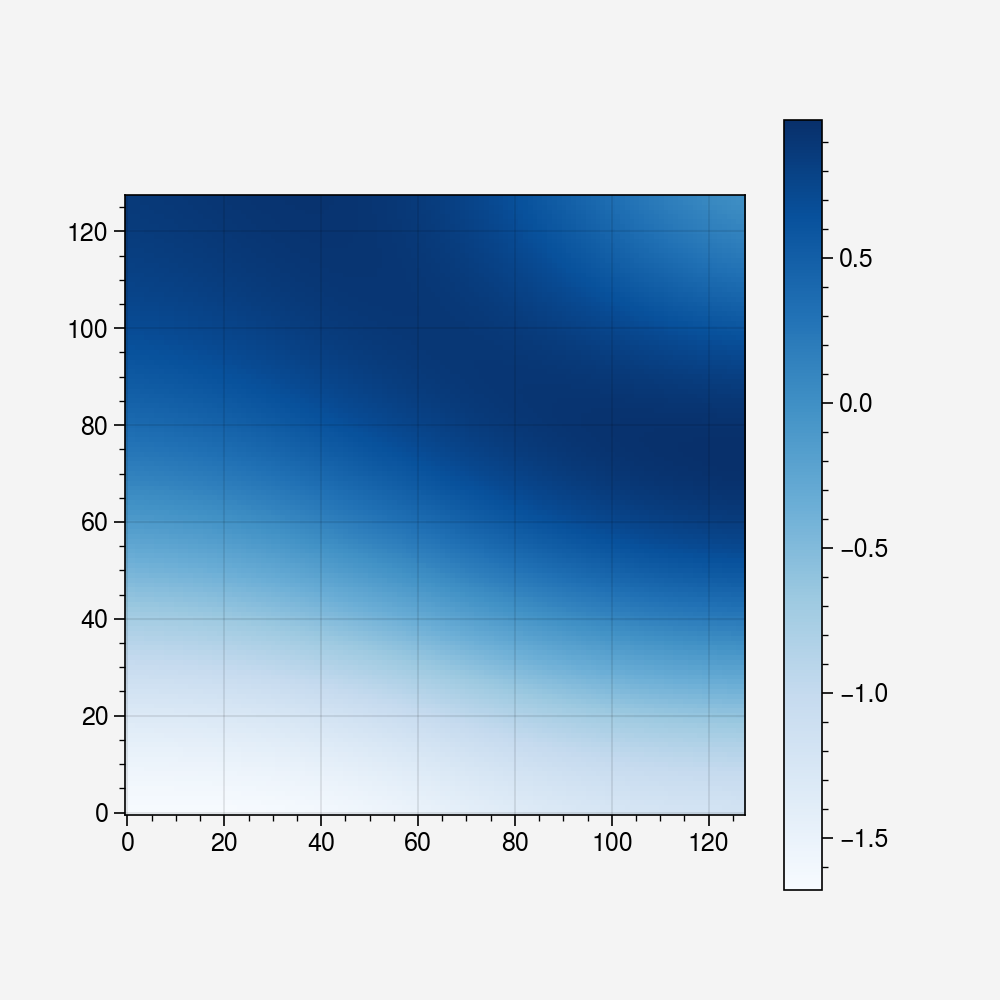

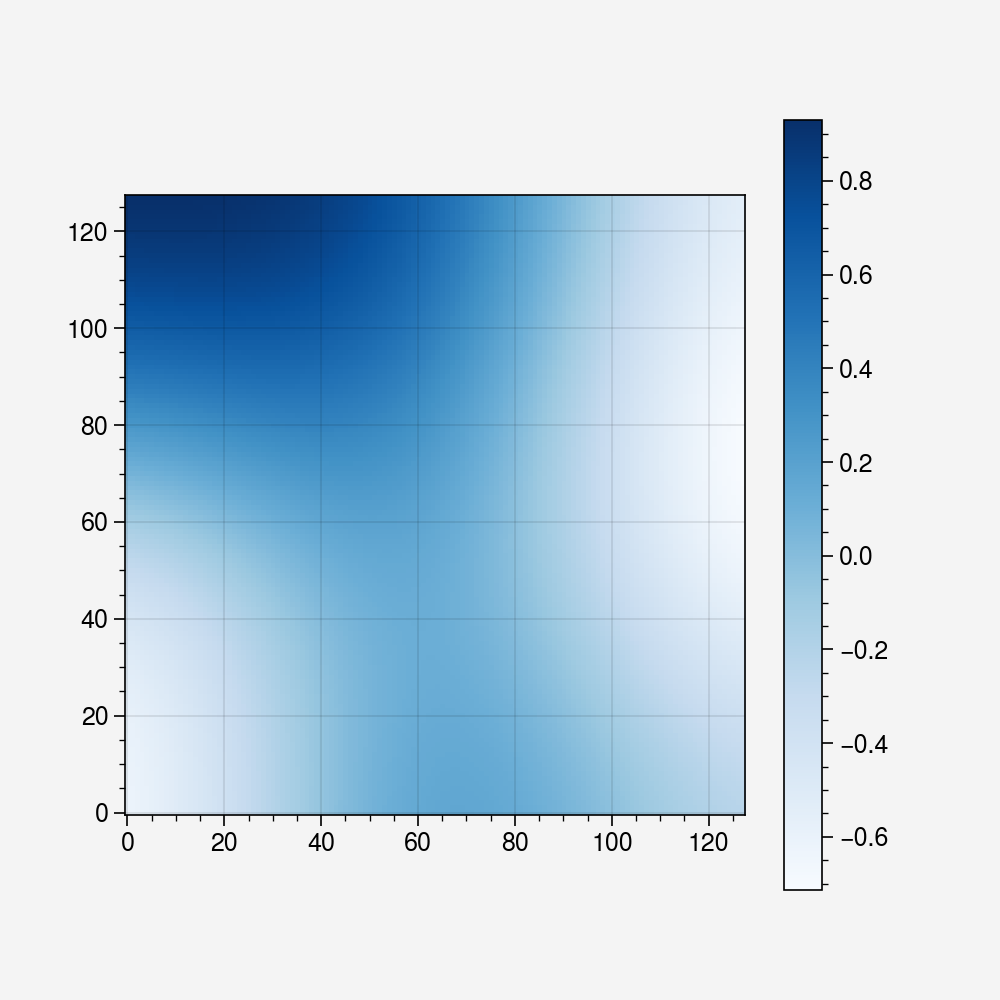

In [12]:
image_train.plot_velocity_field(2, 
                                cmap='Blues');

<a id=synthetic-images-testing-set></a>

### Testing set

[Go to the top](#top-page)

The test set will have 10 image pairs:

In [13]:
n_images = 2

We fix a random seed for generating the test set of PIV images (which is different from the random seed for the training set):

In [14]:
test_random_seed = 200

In [15]:
image_test = generate_images(n_images, test_random_seed)

image_pairs_test = image_test.image_pairs_to_tensor()
targets_test = image_test.targets_to_tensor()

Particles added to the image.
Velocity field added to the image.
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.
Buffers removed from images I1.
Buffers removed from images I2.
Buffers removed from the velocity field.


In [16]:
image_train.save_to_h5({'I': image_pairs_test, 'targets': targets_test}, filename='PIV-dataset-test.h5')

Dataset saved.


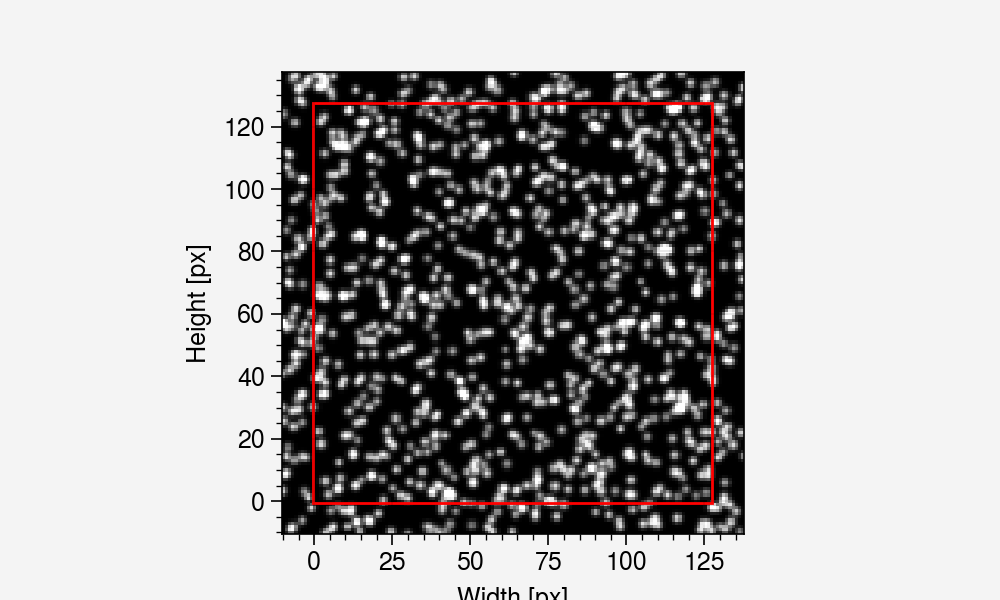

In [17]:
image_test.plot(0,
                instance=1,
                with_buffer=True,
                xlabel='Width [px]',
                ylabel='Height [px]',
                cmap='Greys_r',
                figsize=figsize);

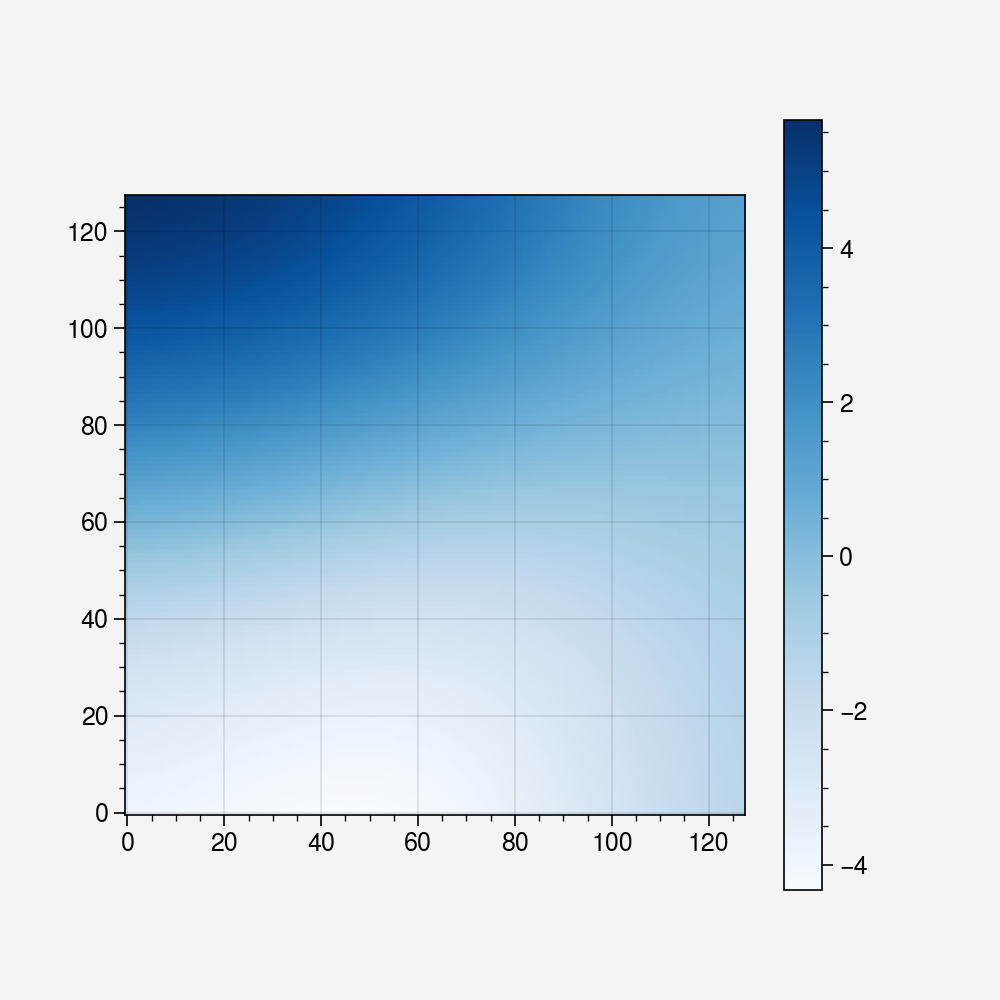

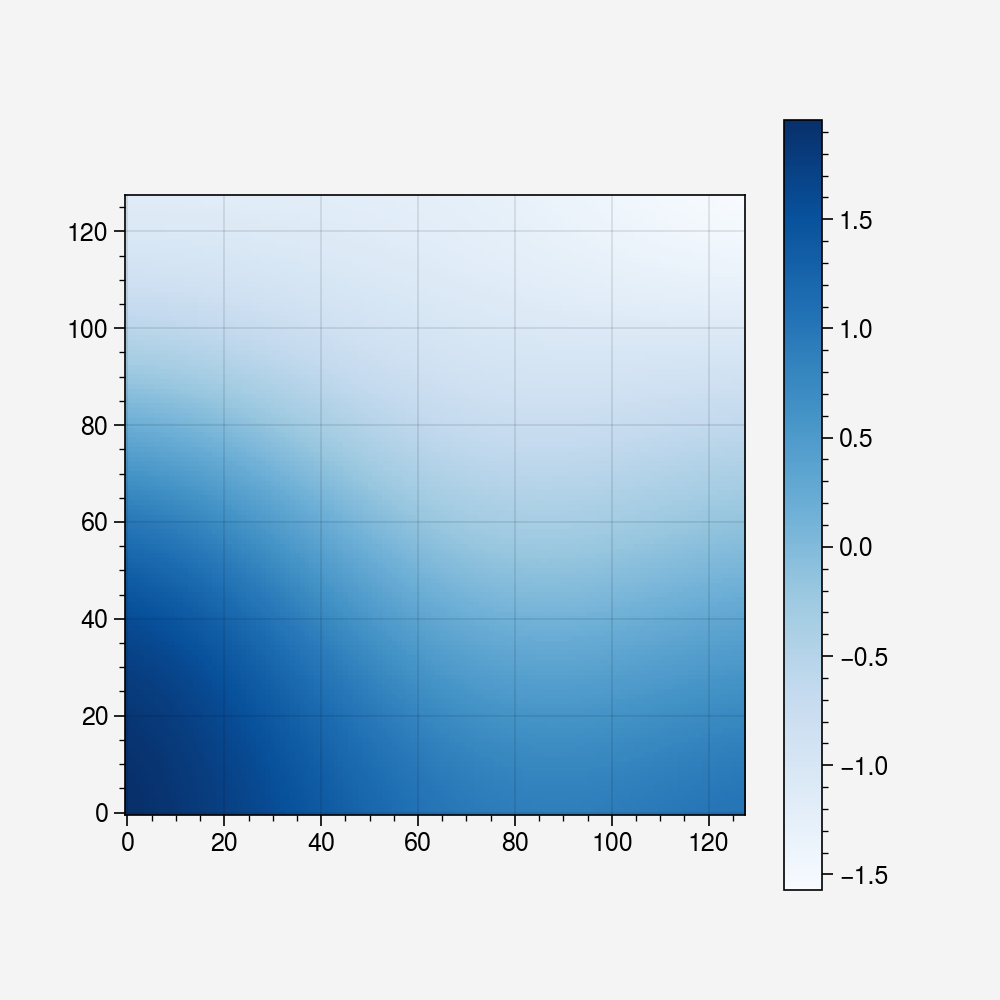

In [18]:
image_test.plot_velocity_field(0,
                               cmap='Blues');

<a id=train-LIMA></a>
***

## Train `LIMA` with the generated images

[Go to the top](#top-page)

<a id=train-LIMA-input-data></a>
### Prepare input dataset for LIMA

[Go to the top](#top-page)

In [19]:
transform = torchvision.transforms.Compose([lima.transforms.RandomAffine(degrees=17, translate=(0.2, 0.2), scale=(0.9, 2.0)),
                                            lima.transforms.RandomHorizontalFlip(),
                                            lima.transforms.RandomVerticalFlip(),
                                            lima.transforms.ToTensor(),
                                            lima.transforms.RandomBrightness(factor=(0.5, 2)),
                                            lima.transforms.RandomNoise(std=(0, 0)),])

#### Use dataset generated with `pykitPIV`:

[Go to the top](#top-page)

In [35]:
# class pykitPIVDataset(Dataset):
#     """Load pykitPIV-generated dataset"""

#     def __init__(self, image_pairs, targets, transform=None, n_samples=None, pin_to_ram=False):

#         self.data = image_pairs
#         self.target = targets

#         if n_samples:
#             self.data = self.data[:n_samples]
#             self.target = self.target[:n_samples]
#         if pin_to_ram:
#             self.data = np.array(self.data)
#             self.target = np.array(self.target)

#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
#         sample = self.data[idx], self.target[idx]
#         if self.transform:
#             sample = self.transform(sample)

#         return sample

In [36]:
# train_dataset = pykitPIVDataset(image_pairs=image_pairs_train,
#                                 targets=targets_train,
#                                 transform=transform)

In [37]:
# test_dataset = pykitPIVDataset(image_pairs=image_pairs_test,
#                                 targets=targets_test,
#                                 transform=transform)

In [20]:
class pykitPIVDatasetFromPath(Dataset):
    """Load pykitPIV-generated dataset"""

    def __init__(self, path, transform=None, n_samples=None, pin_to_ram=False):
        
        f = h5py.File(path, "r")
        self.data = f["I"]
        self.target = np.array(f["targets"])

        print(self.target.max())

        if n_samples:
            self.data = self.data[:n_samples]
            self.target = self.target[:n_samples]
            
        if pin_to_ram:
            self.data = np.array(self.data)
            self.target = np.array(self.target)
            f.close()
            
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = self.data[idx], self.target[idx]
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [21]:
train_dataset = pykitPIVDatasetFromPath(path='PIV-dataset-train.h5',
                                        transform=transform)

7.746831630423369

In [ ]:
train_dataset.__get

In [22]:
train_dataset.data

<HDF5 dataset "I": shape (10, 2, 128, 128), type "<f8">

In [23]:
test_dataset = pykitPIVDatasetFromPath(path='PIV-dataset-test.h5',
                                       transform=transform)

5.661995288692717

#### Use dataset generated with Matlab:

[Go to the top](#top-page)

In [ ]:
# path = 'PIV_n3_s180_maxd10_rnd_v1.h5'

In [ ]:
# f = h5py.File(path, "r")

# images = f["I"]
# images = np.array(images)
# targets = f["target"]
# targets = np.array(targets)[:,2:4,:,:]

# f.close()

In [ ]:
# plt.imshow(np.array(images)[0,0,:,:], cmap='Greys_r')

In [ ]:
# class HDF5Dataset(Dataset):
#     """HDF5Dataset loaded"""

#     def __init__(self, path, transform=None, n_samples=None, pin_to_ram=False):
#         f = h5py.File(path, "r")
#         self.data = f["I"]
#         self.target = np.array(f["target"])[:,2:4,:,:]

#         if n_samples:
#             self.data = self.data[:n_samples]
#             self.target = self.target[:n_samples]
#         if pin_to_ram:
#             self.data = np.array(self.data)
#             self.target = np.array(self.target)
#             f.close()
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
#         sample = self.data[idx], self.target[idx]
#         if self.transform:
#             sample = self.transform(sample)

#         return sample

In [ ]:
# train_dataset = HDF5Dataset(path=path,
#                             transform=transform,)

In [ ]:
# test_dataset = HDF5Dataset(path=path,
#                            transform=transform,)

<a id=train-LIMA-train></a>
### Begin training

[Go to the top](#top-page)

In [24]:
train_loader = DataLoader(train_dataset,
                          batch_size=5,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True)

test_loader = DataLoader(test_dataset,
                         batch_size=10)

In [25]:
random_seed = 100

In [26]:
pl.seed_everything(random_seed, workers=True)

Global seed set to 100


100

In [27]:
len_train_loader = len(train_loader)

Define the LIMA model:

In [28]:
div_flow = 0.05
loss_weights = [0.32, 0.08, 0.02, 0.01, 0.005, 0.0025, 0.00125]
search_range = 4
num_chs = [1, 16, 32, 64, 96, 128, 196]
num_chs = [1, 16, 32]
output_level = 4
loss = 'l1_loss'
loss_weights_order = 'inc'
loss_J = 'abs'
loss_J_gamma = 1e-1
full_res = False
full_res_loss_weight_multiplier = 2.0
n_epochs = 20

In [29]:
model = lima.LIMA(div_flow=div_flow,
                  loss_weights=loss_weights,
                  search_range=search_range,
                  num_chs=num_chs,
                  output_level=output_level,
                  loss=loss,
                  loss_weights_order=loss_weights_order,
                  loss_J=loss_J,
                  loss_J_gamma=loss_J_gamma,
                  full_res=full_res,
                  full_res_loss_weight_multiplier=full_res_loss_weight_multiplier,
                  epochs=n_epochs,
                  optimizer='Adam',
                  base_lr=0.001,
                  weight_decay=4e-4,
                  momentum=0.9,
                  num_workers=20,
                  beta=0.999,
                  reduction="sum",
                  scheduler='ReduceLROnPlateau',
                  lr_decay=0.2,
                  patience=5)

In [30]:
trainer = pl.Trainer(gpus=1, 
                     max_epochs=n_epochs)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [31]:
trainer.fit(model,
            train_loader,
            test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                      | Type             | Params
---------------------------------------------------------------
0 | feature_pyramid_extractor | FeatureExtractor | 16.4 K
1 | warping_layer             | WarpingLayer     | 0     
2 | flow_estimators           | ContextNetwork   | 576 K 
---------------------------------------------------------------
592 K     Trainable params
0         Non-trainable params
592 K     Total params
2.369     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/zdka/miniconda3/envs/lima_lento/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 100
/home/zdka/miniconda3/envs/lima_lento/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/zdka/miniconda3/envs/lima_lento/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:406: UserWarning: The number of training samples (2) is smaller than the loggin

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch     7: reducing learning rate of group 0 to 2.0000e-04.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    13: reducing learning rate of group 0 to 4.0000e-05.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    19: reducing learning rate of group 0 to 8.0000e-06.


Validating: 0it [00:00, ?it/s]

<a id=predict></a>
***

## Make predictions from the trained network

[Go to the top](#top-page)

In [32]:
image_to_predict = 0
velocity_component = 0

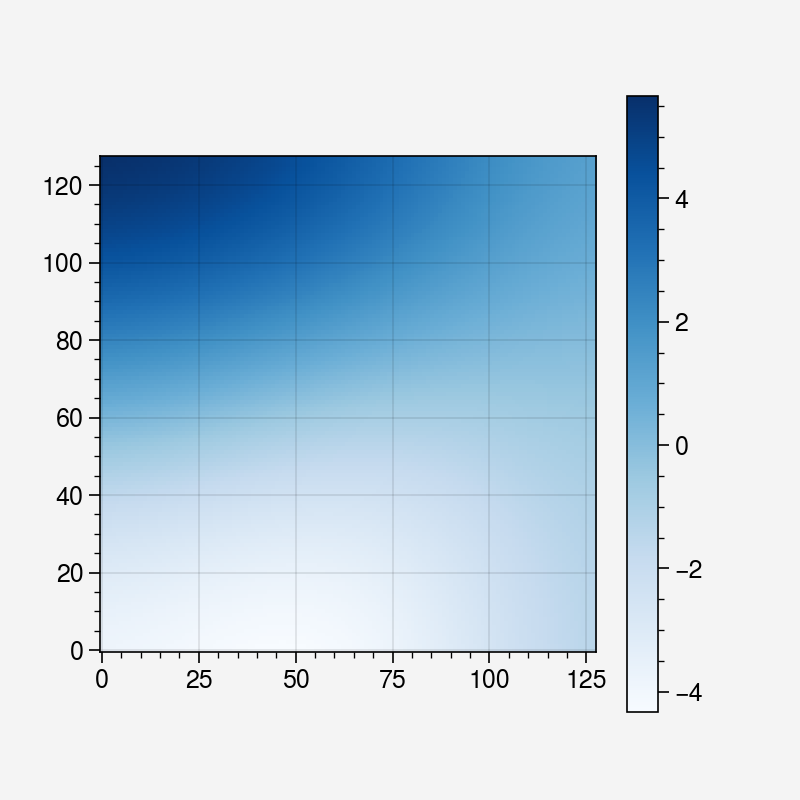

In [33]:
plt.imshow(targets_test[image_to_predict,velocity_component,:,:], 
           cmap='Blues', 
           origin='lower')
plt.colorbar();

In [ ]:
predicted_flow = model.inference(torch.from_numpy(image_pairs_test[0,:,:,:]).to(dtype=torch.float))

In [ ]:
predicted_flow[0][0,velocity_component,:,:].numpy().shape

In [ ]:
plt.imshow(predicted_flow[2][0,velocity_component,:,:].numpy(), 
           cmap='Blues', 
           origin='lower')
plt.colorbar();

In [ ]:
plt.imshow(targets_test[image_to_predict,velocity_component,:,:], 
           cmap='Blues', 
           origin='lower')
plt.colorbar();

***

```
    'batch_size': 4,
    'base_lr': 0.0001,
    'lr_gamma': 0.5,
    'weight_decay': 0.0004,
    'momentum': 0.9,
    'beta': 0.999,
    'milestones': [60, 80, 100, 120, 140],
    'warmup_epochs': 5,
    'optimizer': 'Adam',
    'scheduler': 'ReduceLROnPlateau',
    'epochs': 20,
    'lr_decay': 0.2,
    'patience': 10,
    'noise_std': 0,
    'output_level': 6,
    'loss': 'l1_loss',
    'reduction': 'sum',
    'loss_weights_order': 'inc',
    'loss_J': 'abs',
    'loss_J_gamma': 0.1,
    'full_res': False,
    'full_res_loss_weight_multiplier': 4.0,
    'project': 'test',
    'run': None,
    'log_interval': 5,
    'comment': '',
    'seed': 5738,
    'num_workers': 4,
    'dataset': 'rand_L_lag',
    'logger': True,
    'checkpoint_callback': None,
    'enable_checkpointing': True,
    'default_root_dir': None,
    'gradient_clip_val': None,
    'gradient_clip_algorithm': None,
    'process_position': 0,
    'num_nodes': 1,
    'num_processes': 1,
    'devices': None,
    'gpus': None,
    'auto_select_gpus': False,
    'tpu_cores': None,
    'ipus': None,
    'log_gpu_memory': None,
    'progress_bar_refresh_rate': None,
    'enable_progress_bar': True,
    'overfit_batches': 0.0,
    'track_grad_norm': -1,
    'check_val_every_n_epoch': 1,
    'fast_dev_run': False,
    'accumulate_grad_batches': None,
    'max_epochs': None,
    'min_epochs': None,
    'max_steps': -1,
    'min_steps': None,
    'max_time': None,
    'limit_train_batches': 1.0,
    'limit_val_batches': 1.0,
    'limit_test_batches': 1.0,
    'limit_predict_batches': 1.0,
    'val_check_interval': 1.0,
    'flush_logs_every_n_steps': None,
    'log_every_n_steps': 50,
    'accelerator': None,
    'strategy': None,
    'sync_batchnorm': False,
    'precision': 32,
    'enable_model_summary': True,
    'weights_summary': 'top',
    'weights_save_path': None,
    'num_sanity_val_steps': 2,
    'resume_from_checkpoint': None,
    'profiler': None,
    'benchmark': False,
    'deterministic': False,
    'reload_dataloaders_every_n_epochs': 0,
    'reload_dataloaders_every_epoch': False,
    'auto_lr_find': False,
    'replace_sampler_ddp': True,
    'detect_anomaly': False,
    'auto_scale_batch_size': False,
    'prepare_data_per_node': None,
    'plugins': None,
    'amp_backend': 'native',
    'amp_level': None,
    'move_metrics_to_cpu': False,
    'multiple_trainloader_mode': 'max_size_cycle',
    'stochastic_weight_avg': False,
    'terminate_on_nan': None

```